In [1]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

import notears.notears.notears.utils as utils
import notears.notears.notears.linear as linear

from tqdm import tqdm
from timeit import default_timer as timer
import itertools
import math
from scipy.stats import sem

### Generating Data
Parameters:
- $p$, number of variables.
- $s$, number of arcs.
- $|s|$, size of autoregressive coefficients.
- $T$, number of timesteps.

In [2]:
n, p, s = 100, 5, 10

utils.set_random_seed(seed = 1)
W = utils.simulate_parameter(utils.simulate_dag(p, s, "ER"), w_ranges=((-2.0, -0.5), (0.5, 2.0)))
X = utils.simulate_linear_sem(W, n, "gauss")

[[ 0.         -1.87666118  1.02747896  1.63197154 -0.71325507]
 [ 0.          0.         -1.16274976 -1.15102099 -1.42665047]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.63568902  0.          0.        ]
 [ 0.          0.          0.55892265 -1.32137923  0.        ]]


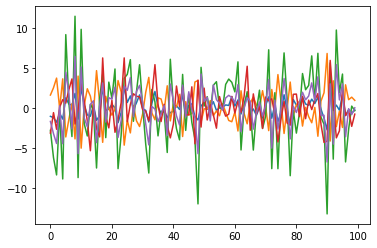

In [3]:
def gen_sem(p, s, n, low = 0.5, high = 2.0, seed = 12345):
    utils.set_random_seed(seed = seed)
    W = utils.simulate_parameter(utils.simulate_dag(p, min(s, int(p * (p - 1) / 2)), "ER"), w_ranges=((-low, -high), (low, high)))
    X = utils.simulate_linear_sem(W, n, "gauss")
    return W, X

n, p, s = 100, 5, 15
W, X = gen_sem(p = p, s = s, n = n, seed = 10)
print(W)
plt.plot(X);

### Generate the datasets

In [4]:
from tqdm import tqdm
datasets = []

p_range = [5, 10, 15, 25, 50]

for p in tqdm(p_range):
    datasets_p = []
    for i in range(10):
        W, X = gen_sem(p, 3 * p, 1000, seed = 10 + i)
        datasets_p.append((W, X))
        # plt.plot(X)
        # plt.show()
    datasets.append(datasets_p)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


In [5]:
def con_OLS(X, B):
    p = np.shape(B)[0]
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ X[:, i]
        
    return W

In [6]:
def expected_MSE_X(W): return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def expected_cost_sem(W_true, W_est):
    """Expected Cost of a Structural Equation Model with X = X W_est, when truth is X = X W_true"""
    
    # base on the distribution of X, no actual data needed.    
    covariance_matrix = (W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est - np.identity(p))
    
    # return expected MSE
    return np.trace(covariance_matrix)

In [7]:
def evaluate(results, X, W_true, W_m, method, epsilon = 0.30, verbose = True):
    # get mse
    _, _, _, _, shd_1, mse, _ = h.score(X, W_m, W_true, is_sem = True, printing = False)
    results[method]['mse'].append(mse)
    
    # do thresholding to get shd
    W_m[np.abs(W_m) <= epsilon] = 0

    _, _, _, _, shd, _, _ = h.score(X, W_m, W_true, is_sem = True, printing = False)
    results[method]['shd'].append(shd)
    
    # do reestimated to get expected mean squared error
    emse = expected_cost_sem(W_true, con_OLS(X, W_m != 0))
    results[method]['emse'].append(emse)
    
    if verbose:
        print(method)
        print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")
        
    return results

In [8]:
# mean squared, true risk, and shd per method
results = {
#     "exh": {"mse": [], "emse": [], "shd": []},
#     "rw_1": {"mse": [], "emse": [], "shd": []},
    "rw_2": {"mse": [], "emse": [], "shd": []},
    "mcmc_r": {"mse": [], "emse": [], "shd": []},
#     "mcmc_t": {"mse": [], "emse": [], "shd": []},
#     "mcmc_s": {"mse": [], "emse": [], "shd": []},
    "mcmc_g": {"mse": [], "emse": [], "shd": []},
    "notears": {"mse": [], "emse": [], "shd": []},
#     "daglasso": {"mse": [], "emse": [], "shd": []},
    "dagomp": {"mse": [], "emse": [], "shd": []},
    "dagols": {"mse": [], "emse": [], "shd": []},
}


In [9]:
import time
iters = 1000

old_time = time.time()
# for each dataset
for dataset in [datasets[-1]]:
    for W, X in dataset:
        
        # for each method:
        T, p = np.shape(X)
        m.T, m.p = T, p
        print(p)
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
    
    # 1: Exhaustive:
#     if p <= 8:
#         W_exh = m.exh(X[:-1], X[1:])
        
#         # 2.1: Random Walk 1, need regularizing
#         W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_1, "rw_1")
    
    # 2.2: Random Walk 2
        W_rw_2 = m.rw_2(X, X, np.identity(p), iters, is_sem = True)[1]
        results = evaluate(results, X, W, W_rw_2, "rw_2")
    
    # 3.1: MCMC 1
        W_mcmc_1 = m.mcmc_1(X, X, iters, np.identity(p), is_sem = True)[1]
        results = evaluate(results, X, W, W_mcmc_1, "mcmc_r")
    
# # #     # 3.2: MCMC 2
# # #     W_mcmc_2 = m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1]
# # #     results = evaluate(results, X, W, W_mcmc_2, "mcmc_t")
    
# # #     # 3.3: MCMC 3
# # #     W_mcmc_3 = m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1]
# # #     results = evaluate(results, X, W, W_mcmc_3, "mcmc_s")
    
    #3.4: MCMC 4
        W_mcmc_4 = m.mcmc_4(X, X, iters, np.identity(p), is_sem = True)[1]
        results = evaluate(results, X, W, W_mcmc_4, "mcmc_g")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
#         W_notears, _ = linear.notears_linear(X, lambda1 = 0.0, loss_type = "l2")
#         results = evaluate(results, X, W, W_notears, "notears")
    
#         print(results["notears"]["mse"][-1])
#         print(results["notears"]["emse"][-1])
#         print(results["notears"]["shd"][-1])
#         # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
# #         W_lassodag, alpha = m._LASSO_LINGNAM(X, step_size = 0.1)
# #         print("DAG-LASSO alpha:", alpha)
# #         results = evaluate(results, X, W, W_lassodag, "daglasso")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
        W_omp, _ = m._K_OMP(X, X, F = [], normalize = True, is_sem = True)
        results = evaluate(results, X, W, W_omp, "dagomp")

        # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
        W_ols_dag = con_OLS(X, B_V_LINGNAM_OLS_Q_SEM(X) != 0)
        results = evaluate(results, X, W, W_ols_dag, "dagols")
        
print(f"Done! Took {time.time() - old_time} seconds.")

  0%|▏                                                                                | 3/1000 [00:00<00:33, 29.41it/s]

50


  2%|█▎                                                                              | 17/1000 [00:00<00:34, 28.33it/s]


KeyboardInterrupt: 

### Plotting

In [ ]:
print(results["rw_2"]["mse"][40:])
print(results["mcmc_r"]["mse"][40:])
print(results["mcmc_g"]["mse"][40:])
print(results["notears"]["mse"][40:])
print(results["dagomp"]["mse"][40:])
# print(results["dagols"]["mse"][40:])

In [ ]:
method = "daglasso"
print(results[method])
results[method]["mse"] = []
results[method]["shd"] = []
results[method]["emse"] = []

In [ ]:
from scipy.stats import sem

In [ ]:
# print(results["notears"]["emse"][-10:])
print(results["notears"]["mse"][:30])
print(results["notears"]["emse"][40:50])
# print(results["notears"]["emse"][20:])
# print(results["notears"]["shd"][28])
# print(results["notears"]["mse"][28])

# results["notears"]["mse"][28] = 18.15573674
# results["notears"]["emse"][28] = 16.0135134613

In [ ]:
shds_notears = [64,90,15,62,114,37,90,30,20,24]
mses_notears = [517.2, 189.7,119.2,2361.1, 4133.6,368.2,3622.5,475.3,252.6,59.1]
emses_notears = [181.7,85.2,62.8,281.8,450.1,70.8,243.4,55.0,51.4,51.0]

# shd_notears_old = results["notears"]["shd"].copy()
for emse in emses_notears:
    results["notears"]["emse"].append(emse)


In [ ]:
for method in results:
    print(method)
    for metric in results[method]:
        print(len(results[method][metric]))
        print(metric, end = "\t")    
        print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(10)])

In [ ]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False


In [ ]:
plt.figure(figsize = (3.0, 2.0))
plt.xlabel("$p$, number of variables")
# plt.ylabel("average empirical risk " + r"$R_{\mathrm{emp}}(W)$")
# plt.ylabel("average true risk " + r"$R(W)$")
plt.ylabel("average SHD")
p_range = [5, 10, 15, 25, 50]
def plot_results(method, metric, results, method_name, linestyle = '-'):
    # plot mean and standard error of DAG-OMP as a function of p.
    plt.plot(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) for i in range(5)], marker = 'o', markersize = 2, linewidth = 1, label = method_name, linestyle = linestyle)
    plt.fill_between(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) - sem(results[method][metric][10*i:10*i + 10])for i in range(5)], [np.mean(results[method][metric][10*i:10*i + 10]) + sem(results[method][metric][10*i:10*i + 10])for i in range(5)], alpha = 0.1)

# plt.ylim(-1, 700)
metric = "shd"

plot_results("rw_2", metric, results, "Random Walk")
plot_results("mcmc_r", metric, results, "MH-R")
plot_results("mcmc_g", metric, results, "MH-G")

plot_results("notears", metric, results, "NO TEARS")
plot_results("dagomp", metric, results, "DAG-OMP")
plot_results("dagols", metric, results, "DAG-OLS-V")

# plot_results("daglasso", metric, results, "DAG-LASSO")
# plt.legend(ncol = 6, loc = 'upper left', bbox_to_anchor=(-0.025, 1.2), columnspacing = 0.75, handletextpad = 0.25)
plt.savefig("semT1000shd.pgf", bbox_inches = 'tight')

In [ ]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}datamatricessemT1000.pkl", "wb")
pickle.dump(datasets, a_file)
a_file.close()

In [ ]:
from datetime import datetime
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}semresultsT1000.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [ ]:
print(results)

In [ ]:
for method in results:
    for metric in results[method]:
        if metric == "emse" and method != "daglasso":
            plt.plot(results[method][metric])

In [ ]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()
    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
       
    # get full OLS solution of W
    B = np.ones((p, p)) - np.identity(p)
    # print(B)
    W = con_OLS(X, B != 0)
    
    # print(np.round(W, 2))
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:, idx].T @ X[:, idx]) @ X[:, idx].T @ X[:, col])
        
        # add edge and score to list
        # order_of_importance.append([row, col])
        # scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
#     while len(np.nonzero(W)[0]) > 0:   
        
#         # set zero values to impossible value
#         W[W == 0] = 1e10
        
#         # get smallest nonzero coefficient in absolute value
#         row, col = np.argmin(np.abs(W)) // p, np.argmin(np.abs(W)) % p
        
#         # set this to zero
#         W[row][col] = 0
        
#         # revert the zero values back to zero
#         W[W == 1e10] = 0

#         edge = [row, col]
        
#         # update column
#         idx = np.nonzero(W[:, col])[0]
#         W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
#         score = h.MSE(W, X)
        
#         if score < tol: 
#             break
            
#         order_of_importance.append(edge)
#         scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return # , order_of_importance, scores

print(W)
W_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
# print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
# print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
print(W_B_V_LINGNAM_OLS)

In [ ]:
W_m = W_B_V_LINGNAM_OLS.copy()

In [ ]:
_, _, _, _, shd_1, mse, _ = h.score(X, W_m, W, printing = False)
# results[method]['mse'].append(mse)


# do thresholding to get shd
W_m[np.abs(W_m) <= 0.30] = 0

_, _, _, _, shd, _, _ = h.score(X, W_m, W, printing = False)
# results[method]['shd'].append(shd)

# do reestimated to get expected mean squared error
emse = expected_cost_var(W, con_OLS(X, W_m != 0))
# results[method]['emse'].append(emse)

if True:
    # print(method)
    print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")


In [ ]:
def in_cycle(W, i, j, epsilon = 1e-32):
    
    h_val = _h(W)
    
    w_tmp = W[i][j]
    W[i][j] = 0
    h_new = _h(W)
    W[i][j] = w_tmp
    
    return np.abs(h_val - h_new) > epsilon

def B_V_LINGNAM_OLS_Q_SEM(X):
    """OLS solution W, data X"""
    
    T, p = np.shape(X)
    
    # get full OLS solution of W
    B = np.ones((p, p)) - np.identity(p)
    # print(B)
    W = con_OLS(X, B != 0)
    
    # non_violators
    violators = np.ones((p, p))
    
    # while we still do not have a DAG
    while not h.is_dag(W):     
        if np.sum(W != 0) % 50 == 0: print(np.sum(W != 0))
        # print(h.is_dag(W))
        
        # find edge with smallest coefficient which might be a violator
        i_list, j_list = np.where((np.abs(W) == np.min(np.abs(W[(W * violators).nonzero()]))))
        i, j = i_list[0], j_list[0]
        
        # if it is contained in a cycle, remove it
        # if not, never consider it again
        if in_cycle(W, i, j):
            W[i][j] = 0
            violators[i][j] = 0
        
            # update column
            idx = np.nonzero(W[:, j])[0]
            W[idx, j] = (np.linalg.inv(X[:, idx].T @ X[:, idx]) @ X[:, idx].T @ X[:, j])
        else:
            violators[i][j] = 0
  
    # return the DAG W
    return W

In [ ]:
X_try = datasets[0][1][1]
T, p = np.shape(X_try)
print(np.shape(X_try))
# W_try_1 = B_V_LINGNAM_OLS(X_try)
# print(np.round(W_try_1, 2))
W_try_2 = B_V_LINGNAM_OLS_Q_SEM(X_try)
print(np.round(W_try_2, 2))

In [ ]:


f_name = "16_06_2022_14_37_56datamatricessemT100sparsenotp50.pkl"
with open(f_name, 'rb') as f:
    datasets = pickle.load(f)

print(np.shape(datasets[3][0][1]))

In [ ]:
f_name = "16_06_2022_14_38_34semsparseT1000notp50.pkl"
with open(f_name, 'rb') as f:
    results = pickle.load(f)

print(results)

In [ ]:
for method in results:
    print(method)
    for metric in results[method]:
        print(len(results[method][metric]))
        print(metric, end = "\t")    
        print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(10)])